In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
#colab stuff
!pip install catboost==1.0.3

!unzip utils.zip

!mkdir data
!wget https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz -P data
!tar xf data/wsdm_data.tar.gz -C data

     |████████████████████████████████| 76.3 MB 1.3 MB/s 
Archive:  utils.zip
   creating: utils/
  inflating: utils/data.py           
   creating: utils/__pycache__/
  inflating: utils/__pycache__/features.cpython-39.pyc  
  inflating: utils/__pycache__/data.cpython-39.pyc  
  inflating: utils/features.py       
--2021-11-27 16:50:33--  https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
Resolving voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)... 52.95.171.48
Connecting to voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)|52.95.171.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613394184 (585M) [application/x-gzip]
Saving to: ‘data/wsdm_data.tar.gz’

wsdm_data.tar.gz    100%[===================>] 584.98M  10.8MB/s    in 57s     

2021-11-27 16:51:30 (10.3 MB/s) - ‘data/wsdm_data.tar.gz’ saved [613394184/613394184]



In [16]:
import os
import numpy as np
import pandas as pd

from utils.data import load_data

from sklearn.model_selection import GroupKFold
from catboost import CatBoostRanker, Pool, MetricVisualizer

In [4]:
SEED = 12
DATA_PATH = "data"

# Data loading & parsing

In [5]:
train = load_data(DATA_PATH, load_test=False) 

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7375811 entries, 0 to 7377417
Data columns (total 27 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   msno                     category
 1   song_id                  category
 2   source_system_tab        category
 3   source_screen_name       category
 4   source_type              category
 5   target                   int64   
 6   city                     category
 7   bd                       category
 8   gender                   category
 9   registered_via           int64   
 10  registration_init_year   category
 11  registration_init_month  category
 12  registration_init_day    category
 13  expiration_year          category
 14  expiration_month         category
 15  expiration_day           category
 16  song_length              float64 
 17  genre_ids                category
 18  artist_name              category
 19  composer                 category
 20  lyricist                

# 1. Ranking with GBDT 

In [7]:
train_group = train.groupby("msno").head(1020).reset_index(drop=True)
train_group.sort_values("msno", kind="stable", inplace=True)

categorical_features = train_group.select_dtypes(["category"]).columns.to_numpy()

In [8]:
X = train_group.drop("target", axis=1)
y = train_group.target.to_numpy()
q = train_group.msno.cat.codes.to_numpy()

In [9]:
catboost_config = {
    "loss_function": "YetiRank", 
    "iterations": 150, 
    "custom_metric": ["NDCG", "QueryAUC:type=Ranking"], 
    "random_seed": SEED, 
    "metric_period": 25,
    "task_type": "GPU",
    "train_dir": "YetiRank/" 
}

In [10]:
scores = []

for train_idx, val_idx in GroupKFold(n_splits=5).split(X, y, q):
    print("START NEW FOLD")
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_val, y_val = X.iloc[val_idx], y[val_idx]
    q_train, q_val = q[train_idx], q[val_idx]

    pool_train = Pool(
        data=X_train, label=y_train, group_id=q_train, 
        cat_features=categorical_features, has_header=True)
    
    pool_val = Pool(
        data=X_val, label=y_val, group_id=q_val, 
        cat_features=categorical_features, has_header=True)
    
    model = CatBoostRanker(**catboost_config)
    model.fit(pool_train, eval_set=pool_val)
    
    scores.append(model.get_evals_result())

START NEW FOLD
Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5166299	best: 0.5166299 (0)	total: 2s	remaining: 4m 57s
25:	test: 0.6613817	best: 0.6613817 (25)	total: 32.7s	remaining: 2m 36s
50:	test: 0.7267847	best: 0.7267847 (50)	total: 1m 3s	remaining: 2m 3s
75:	test: 0.7438933	best: 0.7438933 (75)	total: 1m 34s	remaining: 1m 31s
100:	test: 0.7542267	best: 0.7542267 (100)	total: 2m 5s	remaining: 1m
125:	test: 0.7657907	best: 0.7657907 (125)	total: 2m 36s	remaining: 29.8s
149:	test: 0.7714486	best: 0.7714486 (149)	total: 3m 5s	remaining: 0us
bestTest = 0.7714485659
bestIteration = 149
START NEW FOLD
Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5198204	best: 0.5198204 (0)	total: 1.95s	remaining: 4m 50s
25:	test: 0.7151759	best: 0.7151759 (25)	total: 32.6s	remaining: 2m 35s
50:	test: 0.7447243	best: 0.7447243 (50)	total: 1m 3s	remaining: 2m 2s
75:	test: 0.7608478	best: 0.7608478 (75)	total: 1m 34s	remaining: 1m 31s
100:	test: 0.7656088	best: 0.7656088 (100)	total: 2m 5s	remaining: 1m
125:	test: 0.7753449	best: 0.7753449 (125)	total: 2m 35s	remaining: 29.7s
149:	test: 0.7805177	best: 0.7805177 (149)	total: 3m 5s	remaining: 0us
bestTest = 0.7805176675
bestIteration = 149
START NEW FOLD
Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5271346	best: 0.5271346 (0)	total: 1.95s	remaining: 4m 51s
25:	test: 0.7341614	best: 0.7341614 (25)	total: 32.7s	remaining: 2m 35s
50:	test: 0.7376132	best: 0.7376132 (50)	total: 1m 3s	remaining: 2m 3s
75:	test: 0.7517649	best: 0.7517649 (75)	total: 1m 34s	remaining: 1m 31s
100:	test: 0.7609668	best: 0.7609668 (100)	total: 2m 5s	remaining: 1m
125:	test: 0.7710886	best: 0.7710886 (125)	total: 2m 36s	remaining: 29.7s
149:	test: 0.7735784	best: 0.7735784 (149)	total: 3m 5s	remaining: 0us
bestTest = 0.7735784226
bestIteration = 149
START NEW FOLD
Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5253162	best: 0.5253162 (0)	total: 1.96s	remaining: 4m 51s
25:	test: 0.7263690	best: 0.7263690 (25)	total: 32.7s	remaining: 2m 36s
50:	test: 0.7281983	best: 0.7281983 (50)	total: 1m 3s	remaining: 2m 3s
75:	test: 0.7587149	best: 0.7587149 (75)	total: 1m 34s	remaining: 1m 31s
100:	test: 0.7624963	best: 0.7624963 (100)	total: 2m 5s	remaining: 1m
125:	test: 0.7634150	best: 0.7634150 (125)	total: 2m 36s	remaining: 29.7s
149:	test: 0.7801247	best: 0.7801247 (149)	total: 3m 6s	remaining: 0us
bestTest = 0.7801246804
bestIteration = 149
START NEW FOLD
Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5080697	best: 0.5080697 (0)	total: 1.94s	remaining: 4m 48s
25:	test: 0.6644869	best: 0.6644869 (25)	total: 32.6s	remaining: 2m 35s
50:	test: 0.7341989	best: 0.7341989 (50)	total: 1m 3s	remaining: 2m 3s
75:	test: 0.7596035	best: 0.7596035 (75)	total: 1m 34s	remaining: 1m 31s
100:	test: 0.7699140	best: 0.7699140 (100)	total: 2m 5s	remaining: 1m
125:	test: 0.7756594	best: 0.7756594 (125)	total: 2m 36s	remaining: 29.8s
149:	test: 0.7781343	best: 0.7781343 (149)	total: 3m 5s	remaining: 0us
bestTest = 0.7781343399
bestIteration = 149


## Validation scores

In [14]:
import matplotlib.pyplot as plt

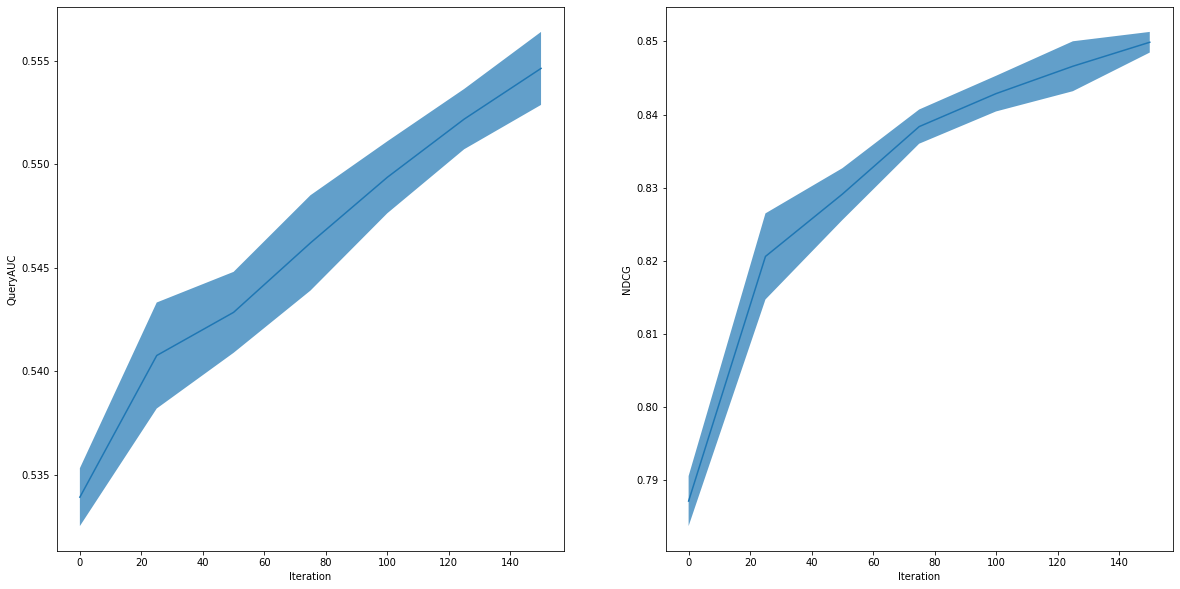

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20, 10))

query_auc = np.vstack([x["validation"]["QueryAUC:type=Ranking"] for x in scores])
auc_mean, auc_std = query_auc.mean(axis=0), query_auc.std(axis=0)

ndcg = np.vstack([x["validation"]["NDCG:type=Base"] for x in scores])
ndcg_mean, ndcg_std = ndcg.mean(axis=0), ndcg.std(axis=0)

x = np.arange(catboost_config["iterations"] // catboost_config["metric_period"] + 1) * catboost_config["metric_period"]

ax1.plot(x, auc_mean)
ax1.fill_between(x, auc_mean - auc_std, auc_mean + auc_std, alpha=0.7)
ax1.set_ylabel("QueryAUC")
ax1.set_xlabel("Iteration")

ax2.plot(x, ndcg_mean)
ax2.fill_between(x, ndcg_mean - ndcg_std, ndcg_mean + ndcg_std, alpha=0.7)
ax2.set_ylabel("NDCG")
ax2.set_xlabel("Iteration");

Есть ощущение, что я сильно недоучил, но catboost даже на gpu обучается недостаточно быстро, чтобы делать перебор параметров или большее количество итераций, иначе colab упадет раньше (или забанит, а он еще для следующей домашки нужен) :\

# 2. Embeddings

TODO